## Texture vs Shape: introduction

<div style="max-width: 60em">

We will look at a modern residual convolutional net. While they perform very well on image classification tasks, some problems they commonly have are that:<br>
* they rely too much on small-scale features (textures) rather than large-scale ones (shape). This often generalizes poorly to unseen datasets and is less human-aligned (e.g. explanations of why a model chose this class may be less interpretable).
* they are very susceptible to adversarial images, i.e. inputs maliciously altered in a way that is imperceptible to humans and shouldn't change the classification, but completely fool the model, making it output high probabilities for unrelated classes.

While the two problems are somewhat related, we focus on the first one.
</div>

## Imports

In [ ]:
import json
import multiprocessing
from collections.abc import Callable, Iterable, Sequence
from copy import deepcopy
from functools import partial
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import torch
import torch.nn
import torch.nn.functional as F
import torchvision.models
import torch.optim.lr_scheduler
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

%matplotlib inline

multiprocessing.set_start_method("spawn", force=True)  # Needed when using CUDA.
torch.set_num_threads(8)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    torch.cuda.set_device(2)

_ = torch.manual_seed(42)

## Datasets

In [ ]:
%%bash
# 219 MiB
# link might be outdated
if [ ! -d datasets ]; then
    gdown https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg \
        && tar -xf datasets.tar.gz \
        && rm datasets.tar.gz
fi

Downloading...
From (original): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg
From (redirected): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg&confirm=t&uuid=a9e5d1c5-6eb2-4e88-9a2c-28197539da19
To: /content/datasets.tar.gz
100%|██████████| 229M/229M [00:02<00:00, 96.6MB/s]


##### MiniImageNet
MiniImageNet is a downscaled subset of ISVLRC ImageNet-1k<sup>[1]</sup> with only 10 classes (RGB, irregular sizes up to 256x256).
Train/val is a uniformly random split, the parts have 2000/100 images per class, respectively.

We will use the *train* part for fine-tuning and *val* for validation and various evaluation.

[1] https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview

['bear', 'bicycle', 'boat', 'bottle', 'car', 'cat', 'chair', 'clock', 'elephant', 'truck']


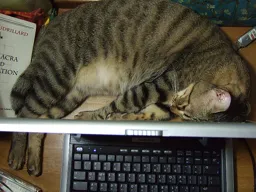

5 cat


In [ ]:
MINI_IMAGENET_PATH = Path("datasets/miniImageNet")
SELECTED_CLASSES = ImageFolder(MINI_IMAGENET_PATH / "train").classes
assert SELECTED_CLASSES == ImageFolder(MINI_IMAGENET_PATH / "val").classes


def example() -> None:  # Note: we scope examples to avoid polluting the global namespace.
    print(SELECTED_CLASSES)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val")
    img, label = dataset[505]
    display(img)
    print(label, dataset.classes[label])


example()

##### eval_transform, display_image_tensor()

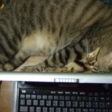

img.shape=torch.Size([3, 112, 112]), img.dtype=torch.float32, min..max=-2.015..2.64
label=5 (cat)


In [ ]:
def get_eval_transform() -> v2.Compose:
    """
    The default transform used on all ImageNet images before passing to a model.

    (Typically papers end up with 224x224 images, we make them smaller for speed.)
    """
    return v2.Compose(
        [
            v2.PILToTensor(),
            v2.Resize(size=128, antialias=True),
            v2.CenterCrop(size=(112, 112)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
        ]
    )


def normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize an image tensor of shape (*B, C, H, W) from 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return (x - mean) / std


def unnormalize(x: torch.Tensor) -> torch.Tensor:
    """Revert an image tensor of shape (*B, C, H, W) to 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return x * std + mean


def display_image_tensor(x: torch.Tensor) -> None:
    """Display a normalized image tensor of shape (C, H, W) as a PIL Image."""
    pil_image: PIL.Image.Image = v2.ToPILImage()(unnormalize(x))
    display(pil_image)


def ceildiv(a: int, b: int) -> int:
    """Return ceil(a /b)."""
    return -(-a // b)


def example() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[505]
    display_image_tensor(img)
    print(f"{img.shape=}, {img.dtype=}, min..max={img.min().item():.4g}..{img.max().item():.4g}")
    print(f"{label=} ({dataset.classes[label]})")


example()

##### alt_test_dataset
This is a dataset with the same classes and some of the same images, but restylized or otherwise altered to mislead models reliant on textures.
We will use this dataset to test if a training method results in a model that is less reliant on textures.
Note that some alterations are pretty heavy, so the images look very different and it is difficult to achieve more than ~40-50% accuracy.

RGB, 224x224, 280 images per class.

(The dataset was created from https://github.com/bethgelab/model-vs-human/releases/tag/v0.1)

cue-conflict 800, edge 100, low-pass 800, silhouette 100, sketch 500, stylized 500, total 2800


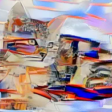

In [ ]:
ALT_TEST_DATASET_PATHS = sorted(Path("datasets/testSets").iterdir())
alt_test_dataset = ConcatDataset([ImageFolder(p, transform=get_eval_transform()) for p in ALT_TEST_DATASET_PATHS])


def example() -> None:
    for p in ALT_TEST_DATASET_PATHS:
        dataset = ImageFolder(p, transform=get_eval_transform())
        assert dataset.classes == SELECTED_CLASSES
        print(p.name, len(dataset), end=", ")
        # display_image_tensor(dataset[int(len(dataset) * 0.53)][0])
    print("total", len(alt_test_dataset))

    img, _label = alt_test_dataset[445]
    display_image_tensor(img)


example()

## Evaluate() and get_dataloader()

Here's an implementation of an evaluation loop, to be used in this notebook.

In [ ]:
def get_dataloader(
    dataset: Dataset,
    shuffle: bool = False,
    batch_size: int = 256,
    num_workers: int = 2,
    pin_memory: bool = True,
    prefetch_factor: int = 2,
    persistent_workers: bool = True,
    timeout: float = 30.0,
    **kwargs: Any,
) -> DataLoader:
    """DataLoader constructor with different defaults."""
    if num_workers == 0:
        pin_memory = False
        persistent_workers = False
        prefetch_factor = None
        timeout = 0.0

    return DataLoader(
        dataset,
        shuffle=shuffle,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        prefetch_factor=prefetch_factor,
        persistent_workers=persistent_workers,
        timeout=timeout,
        **kwargs,
    )

In [ ]:
def evaluate(
    model: torch.nn.Module,
    dataloader: Dataset | DataLoader,
    description: str = "eval",
    device: str = DEVICE,
    quiet: bool = False,
    use_workers: bool = True,
) -> float:
    """Evaluate a model on a dataset or dataloader, returning the accuracy (0..1)."""
    model = model.to(device).eval()
    if not isinstance(dataloader, DataLoader):  # Create from dataset.
        if use_workers:
            dataloader = get_dataloader(dataloader, persistent_workers=False)
        else:
            dataloader = get_dataloader(dataloader, num_workers=0)

    accuracy, n_done, n_correct = 0, 0, 0

    progress_bar = tqdm(dataloader, desc=description, disable=quiet, delay=0.5)
    with torch.no_grad(), progress_bar:
        for image_batch, label_batch in progress_bar:
            logits_batch = model(image_batch.to(device))
            predictions = logits_batch.argmax(dim=1)

            n_done += len(label_batch)
            n_correct += (predictions == label_batch.to(device)).sum().item()
            accuracy = n_correct / n_done if n_done else 0
            progress_bar.set_postfix({"accuracy": f"{accuracy * 100:.1f} %"})

    return accuracy

## 0. Model, remapping the classification layer

We will use a ready-made model pretrained on ImageNet-1k.<br>
Since they all output logits for 1000 classes (`IMAGENET_CATEGORIES`),<br>
we need to alter the classification layer to output logits for the 10 MiniImageNet classes instead (`SELECTED_CLASSES`).<br>
Note that several ImageNet-1k classes can map to the same MiniImageNet class.<br>


In [ ]:
SELECTED_MODEL = (torchvision.models.efficientnet_b0, torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
# 5.3M params, 78% acc@1 on original ImageNet-1k

# Other models we considered, but cut for time:
# * (torchvision.models.mobilenet_v3_small, torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
#     2.5M params, 68% acc@1
# * (torchvision.models.resnet18, torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
#     11.7M params, 70% acc@1 on original ImageNet-1k
# * (torchvision.models.efficientnet_v2_s, torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
#     21.5M params, 84% acc@1

IMAGENET_CATEGORIES = SELECTED_MODEL[1].meta["categories"]
assert IMAGENET_CATEGORIES == torchvision.models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]
print(len(IMAGENET_CATEGORIES), ", ".join(IMAGENET_CATEGORIES[:7] + ["..."]))

1000 tench, goldfish, great white shark, tiger shark, hammerhead, electric ray, stingray, ...


In [ ]:
# Some technical details, feel free to ignore.


def _load_imagenet_id_to_class_id_map(classes: Sequence[str] = SELECTED_CLASSES) -> dict[int, int]:
    """
    Return a map from imagenet ids 0..999 to selected class ids: 0..len(classes)-1.

    Classes should be a subset of the following 16 class names:
        airplane,bear,bicycle,bird,boat,bottle,car,cat,chair,clock,dog,elephant,keyboard,knife,oven,truck
    """
    imagenet_id_to_name = {i: name for i, name in enumerate(IMAGENET_CATEGORIES)}
    class_to_idx = {name: i for i, name in enumerate(classes)}
    with open("datasets/imagenet_name_to_synset_id.json") as f:
        name_to_synset = json.load(f)
    with open("datasets/synset_id_to_class.json") as f:
        synset_to_class = json.load(f)
    # Not all synsets defined in synset_id_to_class.json are present in ImageNet-1k
    # (they also don't appear in our dataset 10-class-ImageNet).
    imagenet_name_to_class_name = {
        name: synset_to_class[synset] for name, synset in name_to_synset.items() if synset in synset_to_class
    }

    result = dict[int, int]()
    for imagenet_id, imagenet_name in imagenet_id_to_name.items():
        # Not all imagenet names are present in 10-class-ImageNet, obviously.
        if imagenet_name in imagenet_name_to_class_name:
            class_name = imagenet_name_to_class_name[imagenet_name]
            # Not all class names defined for 16-class-ImageNet are present in our dataset 10-class-ImageNet.
            if class_name in class_to_idx:
                result[imagenet_id] = class_to_idx[class_name]

    for k, v in result.items():
        assert 0 <= k < len(IMAGENET_CATEGORIES) and 0 <= v < len(classes)

    return result


def _reset_model_weights(model: torch.nn.Module) -> None:
    """Reinitialize the model weights randomly. We probably won't use it."""
    # Some models define reset_parameters(), but unfortunately not all.
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_out")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.BatchNorm2d | torch.nn.GroupNorm):
            torch.nn.init.ones_(m.weight)
            torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.Linear):
            init_range = 1.0 / np.sqrt(m.out_features)
            torch.nn.init.uniform_(m.weight, -init_range, init_range)  # EfficientNet v1
            # torch.nn.init.normal_(m.weight, 0, 0.01)  # MobileNet v3
            torch.nn.init.zeros_(m.bias)

In [ ]:
def remap_output_layer(layer: torch.nn.Linear, id_map: dict[int, int]) -> torch.nn.Module:
    """Return a new final classification logit layer where the i-th class becomes id_map[i] instead."""
    assert layer.out_features == len(IMAGENET_CATEGORIES)

    new_layer = torch.nn.Linear(layer.in_features, len(set(id_map.values())))

    new_weights = torch.zeros_like(new_layer.weight)
    new_bias = torch.zeros_like(new_layer.bias)

    mini_imagenet_weights = {}
    mini_imagenet_biases = {}
    mini_imagenet_count = {}

    for imagenet_id, mini_imagenet_id in id_map.items():
      if mini_imagenet_id not in mini_imagenet_weights:
        mini_imagenet_weights[mini_imagenet_id] = torch.zeros_like(new_layer.weight[0])
        mini_imagenet_biases[mini_imagenet_id] = 0
        mini_imagenet_count[mini_imagenet_id] = 0
      mini_imagenet_weights[mini_imagenet_id] += layer.weight[imagenet_id]
      mini_imagenet_biases[mini_imagenet_id] += layer.bias[imagenet_id]
      mini_imagenet_count[mini_imagenet_id] += 1

    # average of weights and biases
    # i also tried sum, but mean gave better results
    for mini_imagenet_id in mini_imagenet_weights:
      new_weights[mini_imagenet_id] = mini_imagenet_weights[mini_imagenet_id] / mini_imagenet_count[mini_imagenet_id]
      new_bias[mini_imagenet_id] = mini_imagenet_biases[mini_imagenet_id] / mini_imagenet_count[mini_imagenet_id]

    new_layer.weight.data = new_weights
    new_layer.bias.data = new_bias

    return new_layer


"""
Feedback for better accuracy:
A more principled solution is to sum up the probabilities,
instead of logits: if we really believe there is x% chance
that the image represents "ice bear" and a y% chance of
"brown bear" etc., then we believe there is "x + y + ... %"
chance of getting either of them (the classes are disjoint).

This corresponds to running the original layer to get 1000 logits,
apply softmax, sum the right classes, and return the log of that.
This can be simplified to logSumExp. This achieved an accuracy of
93.9%, and maintained some of that elevated accuracy even after
fine-tuning, even on the alt dataset sometimes (though not always
and I didn't test that thoroughly). Keeping the original layer
whole is not a significant cost compared to the whole model.

The same 93.9% accuracy could also be achieved by running the
original layer and returning (as the logit for MiniImageNet
class i) the value of the maximum logit among contributing
subclasses (the ImageNet classes mapping to i). This is not
the same as taking the max of weights, and who is the maximum depends
on the input.
"""

# My side note
# Why does id_map have more keys (imagenet IDs) than unique values (mini-imagenet IDs)?
id_map = _load_imagenet_id_to_class_id_map(SELECTED_CLASSES)
inv_map = {}
for k, v in id_map.items():
    inv_map[SELECTED_CLASSES[v]] = inv_map.get(SELECTED_CLASSES[v], []) + [IMAGENET_CATEGORIES[k]]
print(inv_map) # imagenet IDs are more "specialized"


{'cat': ['tabby', 'tiger cat', 'Persian cat', 'Siamese cat', 'Egyptian cat', 'cougar'], 'bear': ['brown bear', 'American black bear', 'ice bear', 'sloth bear'], 'elephant': ['Indian elephant', 'African elephant'], 'clock': ['analog clock', 'digital clock', 'wall clock'], 'chair': ['barber chair', 'folding chair', 'rocking chair', 'throne'], 'car': ['beach wagon', 'convertible', 'sports car'], 'bottle': ['beer bottle', 'pill bottle', 'pop bottle', 'water bottle', 'water jug', 'whiskey jug', 'wine bottle'], 'bicycle': ['bicycle-built-for-two', 'mountain bike'], 'boat': ['canoe', 'fireboat', 'lifeboat', 'speedboat', 'yawl'], 'truck': ['fire engine', 'garbage truck', 'minivan', 'moving van', 'pickup', 'police van', 'tow truck', 'trailer truck']}


In [ ]:
def get_model(
    eval: bool = False, reset: bool = False, selected_classes: Sequence[str] = SELECTED_CLASSES
) -> torch.nn.Module:
    model_fn, model_weights = SELECTED_MODEL
    model = model_fn(weights=model_weights)

    # Find and replace the last Linear layer.
    id_map = _load_imagenet_id_to_class_id_map(selected_classes)
    last_linear_layer = None
    for parent_module in model.modules():
        for name, layer in parent_module.named_children():
            if isinstance(layer, torch.nn.Linear):
                last_linear_layer = (parent_module, name, layer)
    assert last_linear_layer is not None
    parent_module, name, layer = last_linear_layer

    setattr(parent_module, name, remap_output_layer(layer, id_map))

    if reset:
        _reset_model_weights(model)

    return model.eval() if eval else model.train()


get_model(eval=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def example_remapping() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    model = get_model(eval=True)
    evaluate(model, dataset)

example_remapping()

eval: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it, accuracy=90.3 %]


## Training

Here's an implementation of a training loop that we will use for this notebook.

In [ ]:
BATCH_NORM_TYPES = (
    torch.nn.BatchNorm1d
    | torch.nn.BatchNorm2d
    | torch.nn.BatchNorm3d
    | torch.nn.SyncBatchNorm
    | torch.nn.LazyBatchNorm1d
    | torch.nn.LazyBatchNorm2d
    | torch.nn.LazyBatchNorm3d
)


class Trainer:
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = DEVICE,
        extra_augmentation: v2.Transform | None = None,
        use_workers: bool = True,
    ):
        self.lr = lr
        self.weight_decay = weight_decay
        self.n_epochs = n_epochs
        self.device = device
        self.batch_norm_momentum = batch_norm_momentum
        if extra_augmentation is not None:
            self.extra_augmentation = v2.RandomApply([extra_augmentation], p=0.5)
        else:
            self.extra_augmentation = v2.GaussianBlur(kernel_size=9, sigma=(0.1, 9.0))
        self.num_workers = 2 if use_workers else 0

    def get_train_transform(self) -> v2.Transform:
        return v2.Compose(
            [
                v2.PILToTensor(),
                v2.RandomResizedCrop(size=(112, 112), antialias=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.AutoAugment(interpolation=v2.InterpolationMode.BILINEAR),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                self.extra_augmentation,
                v2.RandomErasing(p=0.2),
                v2.ToPureTensor(),
            ]
        )

    def get_train_dataloader(self) -> DataLoader:
        transform = self.get_train_transform()
        train_dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
        return get_dataloader(train_dataset, shuffle=True, num_workers=self.num_workers)

    def get_eval_dataloaders(self) -> dict[str, DataLoader]:
        transform = get_eval_transform()
        val_dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
        return {
            "val": get_dataloader(val_dataset, num_workers=self.num_workers),
            "alt": get_dataloader(alt_test_dataset, num_workers=self.num_workers),
        }

    def get_optimizer_and_scheduler(
        self, parameters: Iterable[torch.nn.Parameter]
    ) -> tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LRScheduler]:
        optimizer = torch.optim.AdamW(parameters, lr=self.lr, weight_decay=self.weight_decay, fused=True)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
        return optimizer, lr_scheduler

    def do_evaluations(self, model: torch.nn.Module, eval_dataloaders: dict[str, DataLoader]) -> dict[str, float]:
        result = dict[str, float]()
        for k, d in eval_dataloaders.items():
            result[k] = evaluate(model, d, description=k, quiet=True)
            print(f"{k}={result[k] * 100:.1f} %", end="\t", flush=True)
        print()
        return result

    def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
        model = model.to(self.device)

        if self.batch_norm_momentum is not None:
            # Default torch.nn.BatchNorm2D.momentum is 0.1, but it's often too high.
            for m in model.modules():
                if isinstance(m, BATCH_NORM_TYPES):
                    m.momentum = self.batch_norm_momentum

        train_dataloader = self.get_train_dataloader()
        eval_dataloaders = self.get_eval_dataloaders()
        optimizer, lr_scheduler = self.get_optimizer_and_scheduler(model.parameters())

        results = {k: [] for k in eval_dataloaders.keys()}
        for k, v in self.do_evaluations(model, eval_dataloaders).items():
            results[k].append(v)

        for epoch in range(1, self.n_epochs + 1):
            self.train_epoch(model, train_dataloader, optimizer, epoch)
            lr_scheduler.step()

            for k, v in self.do_evaluations(model, eval_dataloaders).items():
                results[k].append(v)

        return results

    def train_epoch(
        self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()
        n_correct = 0
        n_total = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

            optimizer.zero_grad()
            logits_batch = model(image_batch)
            loss = torch.nn.CrossEntropyLoss()(logits_batch, label_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                n_correct += (logits_batch.argmax(dim=1) == label_batch).sum().item()
                n_total += len(label_batch)
            accuracy = n_correct / n_total
            progress_bar.set_postfix({"train-acc": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})


## 1. Implementing augmentations

In this task, a few transformations that can help in assessing whether a model relies more on texture or shape information are implemented.

In all cases, the transform takes a normalized image of shape `(*B, C, H, W)` (where `*B` represents any number of extra dimensions, possibly none) and dtype `float32`, and it outputs the same.
Do not change the tensor's device (it will be CPU).


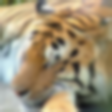

In [ ]:
def example_transformed(transform: Callable[[torch.Tensor], torch.Tensor], image_id: int = 510, seed: int = 42) -> None:
    torch.manual_seed(seed)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[image_id]
    with torch.no_grad():
        img = transform(img)
    display_image_tensor(img)


def benchmark_transform(transform: v2.Transform) -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
    dataset = Subset(dataset, range(2500))
    dataloader = get_dataloader(dataset, batch_size=256, num_workers=0)
    for _image_batch, _label_batch in tqdm(dataloader):
        pass


example_transformed(v2.GaussianBlur(kernel_size=25, sigma=2.0), 513)

#### 1a: Blur
A transformation that blurs the image.<br>
The transform is parameterized by strength (from roughly 1 meaning no/minimal blurring to 100 meaning the image becomes unrecognizable to humans).<br>

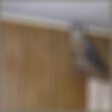

In [ ]:
def blur(x: torch.Tensor, strength: int = 10) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    *B, C, H, W = x.shape

    has_batch = len(B) > 0
    B = B[0] if has_batch else 1

    if not has_batch:
        x = x.unsqueeze(0) # (1, C, H, W)

    # # even number size kernel warning with padding="same"
    # if not strength % 2:
    #     strength += 1

    # like box-blur
    x = F.conv2d(x, torch.ones((C, 1, strength, strength)) / (strength**2), padding="same", groups=C)

    if not has_batch:
        x = x.squeeze(0) # (C, H, W)

    return x

example_transformed(blur, 507)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(blur)]))

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


#### 1b: Pixelize
A transformation that averages blocks of `block_height x block_width` pixels, as in the example below.

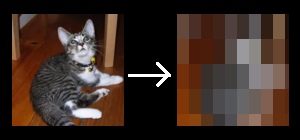

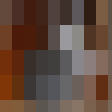

In [ ]:
def pixelize(x: torch.Tensor, block_height: int = 8, block_width: int = 8) -> torch.Tensor:
    assert 1 <= block_height and 1 <= block_width, f"Expected ≥1, got {block_height=}, {block_width=}."
    
    *B, C, H, W = x.shape

    has_batch = len(B) > 0
    B = B[0] if has_batch else 1

    if not has_batch:
        x = x.unsqueeze(0) # (1, C, H, W)

    pad_height = (block_height - (H % block_height)) % block_height
    pad_width = (block_width - (W % block_width)) % block_width
    x = F.pad(x, (0, pad_width, 0, pad_height)) # (B, C, H + pad_height, W + pad_width)
    padded_H, padded_W = x.shape[2], x.shape[3]

    x = x.unfold(2, block_height, block_height).unfold(3, block_width, block_width) # (B, C, n_blocks_H, n_blocks_W, block_height, block_width)
    x = x.mean(dim=(-1, -2)) # (B, C, n_blocks_H, n_blocks_W)

    # display_image_tensor(x[0])
    x = x.repeat_interleave(block_height, dim=2).repeat_interleave(block_width, dim=3) # (B, C, padded_H, padded_W)
    x = x[:, :, :H, :W]

    if not has_batch:
        x = x.squeeze(0) # (C, H, W)

    return x

example_transformed(lambda x: pixelize(x, 25, 12), 510)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(pixelize)]))

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


#### 1c: Noise

A transformation that adds noise (same on each channel, up to normalization constants) to an image.<br>
Parameterized by noise strength (from 1 unnoticeable to 100 unrecognizable) and grain size (roughly in pixels), as in the four examples below.<br>

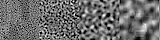

In [ ]:
def noise(x: torch.Tensor, strength: int = 20, grain_size: int = 10) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    assert 1 <= grain_size <= 100, f"Expected 1 ≤ grain_size ≤ 100, got {grain_size}."

    *B, C, H, W = x.shape
    has_batch = len(B) > 0
    B = B[0] if has_batch else 1

    if not has_batch:
        x = x.unsqueeze(0) # (1, C, H, W)

    noise_h = H // grain_size
    noise_w = W // grain_size

    noise_grid = torch.randn((B, 1, noise_h, noise_w))
    noise = F.interpolate(noise_grid, size=(H, W), mode='bilinear')
    # display_image_tensor(noise[0])

    noise *= strength / 10 # scale strength to match description
    x = x + noise # add by broadcast along channels

    # Feedback:
    # Expected unnormalize(noise(x, strength=99, grain_size=6))
    # to be clamped to 0..255, got -1407.904..1268.849.
    x = x.clamp(x, 0, 255)

    if not has_batch:
        x = x.squeeze(0) # (C, H, W)

    return x

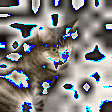

In [ ]:
example_transformed(noise, 506)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(noise)]))

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


## 2. Comparing augmentations

Focus on the readability of the presented results.

Note: to use transforms defined in a notebook, `evaluate()` is called with `use_workers=False`<br>
(this is because functions are pickled by reference, and those defined in a notebook cannot be imported by workers spawned by a dataloader;<br>
other workarounds include writing a Python module e.g. with `%%writefile file.py`, or using the `cloudpickle` package, but we prefer to keep it simple here).

#### Side note: lambdas in for loops

Since in this task it may be useful to use lots of lambdas (to change default parameters in your transformations),<br>
we would like to warn about one potential pitfall here.<br>

One 'gotcha' in Python is that 'for' variables (and similar blocks) are not scoped to the loop body,<br>
they continue with the value from the last iteration.

In [ ]:
def example() -> None:
    for i in range(3):
        for j in range(3):
            pass
        print(j)


example()

2
2
2


This is sometimes useful and mostly benign, but we may overlook using the wrong variable.

Another gotcha is that closures in Python (lambdas or def-s using variables from external scopes)<br>
are *late-binding*, meaning variables are captured by reference,<br>
so especially together with the previous gotcha, we get a probably-not-so-intuitive result:

In [ ]:
def example() -> None:
    funcs = [(lambda x: x + a) for a in range(3)]
    for f in funcs:
        print(f(0))

example()

2
2
2


Use `lambda x, a=a: f(x,a)` or `functools.partial(f, a=a)` to capture by value instead.

(A linter like [ruff](https://docs.astral.sh/ruff/) will warn about both gotchas, by detecting e.g. [unused loop variables](https://docs.astral.sh/ruff/rules/unused-loop-control-variable/) and [loop variables used in closures](https://docs.astral.sh/ruff/rules/function-uses-loop-variable/), unfortunately there is no easy way to use them in Colab).

#### 2a: On vanilla model

Comparison of how `get_model()` performs on inputs from the `val` dataset, when transformed with your transformations (one at a time) or with `v2.GaussianBlur`, using different transform parameters.


In [ ]:

model = get_model(eval=True)

def gaussian_blur_transform(x, p):
    return v2.GaussianBlur(25, p)(x)

def blur_transform(x, p):
    return blur(x, 2*p)

def pixelize_transform(x, p):
    return pixelize(x, 2*p, p)

def noise_transform(x, p):
    return noise(x, 2*p, p)

# parameter sets are kind of arbitrary, but manual testing shows
# they correspond well to gradual obscuring of images from slight
# (p=1) to almost unrecognizable (p=16)
ps = [p for p in range(1, 17, 5)]

transformations = {
    "GaussianBlur": [(p, gaussian_blur_transform) for p in ps],
    "blur": [(p, blur_transform) for p in ps],
    "pixelize": [(p, pixelize_transform) for p in ps],
    "noise": [(p, noise_transform) for p in ps],
}

accuracies = {
    "GaussianBlur": [],
    "blur": [],
    "pixelize" : [],
    "noise" : []
}

for name in transformations:
    for p, func in transformations[name]:
        print(f"Running {name} with p={p}...")
        val = ImageFolder(
            MINI_IMAGENET_PATH / "val",
            transform=v2.Compose([
                get_eval_transform(),
                v2.Lambda(lambda x, p=p, func=func: func(x, p))
            ])
        )
        dataloader = get_dataloader(val, batch_size=100, num_workers=0)
        accuracies[name].append(evaluate(model, dataloader))


Running GaussianBlur with p=1...


eval: 100%|██████████| 10/10 [00:30<00:00,  3.10s/it, accuracy=83.5 %]


Running GaussianBlur with p=6...


eval: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s, accuracy=31.4 %]


Running GaussianBlur with p=11...


eval: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s, accuracy=29.6 %]


Running GaussianBlur with p=16...


eval: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s, accuracy=29.7 %]


Running blur with p=1...


eval: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s, accuracy=87.7 %]


Running blur with p=6...


eval: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s, accuracy=45.4 %]


Running blur with p=11...


eval: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it, accuracy=26.1 %]


Running blur with p=16...


eval: 100%|██████████| 10/10 [00:41<00:00,  4.13s/it, accuracy=20.5 %]


Running pixelize with p=1...


eval: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s, accuracy=86.0 %]


Running pixelize with p=6...


eval: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s, accuracy=20.7 %]


Running pixelize with p=11...


eval: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s, accuracy=13.0 %]


Running pixelize with p=16...


eval: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s, accuracy=12.1 %]


Running noise with p=1...


eval: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s, accuracy=85.1 %]


Running noise with p=6...


eval: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s, accuracy=23.7 %]


Running noise with p=11...


eval: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s, accuracy=10.5 %]


Running noise with p=16...


eval: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s, accuracy=9.9 %]


**Short summary**

In order to keep the task simple, but still comprehensive, a set of parameters was chosen that revolves around a variable `p`, that corresponds to a gradual increase in obscuring the image from almost untouched to almost unrecognizable, for all of the augmentation functions.

The results show that the accuracy of the model drops as the strengths for each of the augmentation functions increase. For some, even the slightest of augmentations causes a drop in the accuracy (e.g. from the original \~90% to \~83% with GaussianBlur with `p=1`). Moreover, some functions, like pixelize and noise functions, make the model's accuracy drop to \~20-25%, almost as soon as the parameters get higher than $p=1$ (minimal augmentation, practically imperceivable).

These results highlight the sensitivity of the model to different types and degrees of perturbations in data.

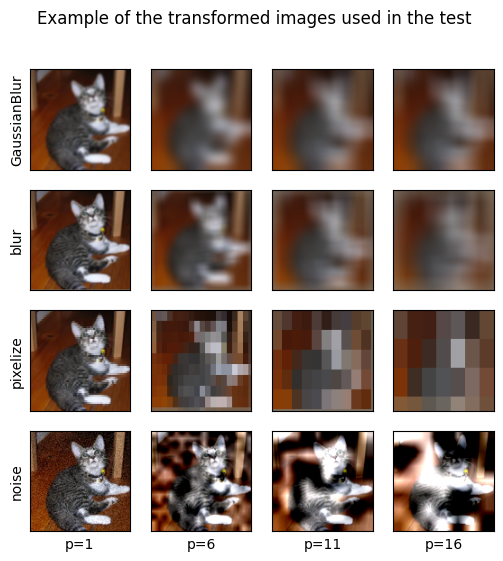

In [ ]:
# Image visualizations

def example_transformed_with_return(transform: Callable[[torch.Tensor], torch.Tensor], image_id: int = 510, seed: int = 42):
    torch.manual_seed(seed)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[image_id]
    with torch.no_grad():
        img = transform(img)
    return img

fig, axes = plt.subplots(4, 4, figsize=(6, 6))

i = 0
j = 0
for name in transformations:
    for p, func in transformations[name]:
        image = example_transformed_with_return(lambda x: func(x, p))
        image = unnormalize(image)
        image = image.permute(1, 2, 0)
        image = image.clip(0, 1)
        axes[i, j].imshow(image)
        # axes[i, j].axis('off')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        if j == 0:
            axes[i, j].set_ylabel(name)
        if i == 3:
            axes[i, j].set_xlabel(f"p={p}")
        j += 1
    i += 1
    j = 0

plt.suptitle("Example of the transformed images used in the test")
plt.show()
plt.close()

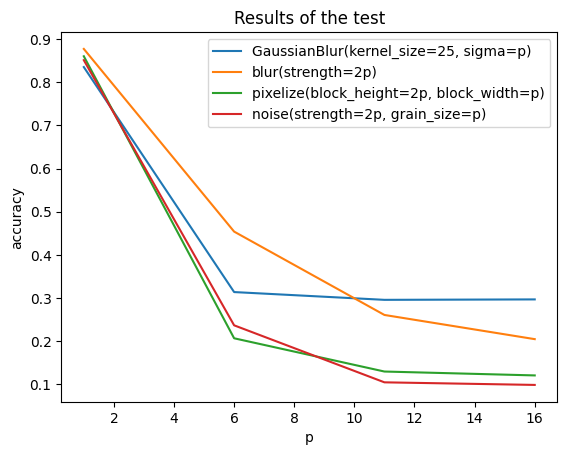

In [ ]:
# Results visualization
plt.plot(ps, accuracies["GaussianBlur"], label="GaussianBlur(kernel_size=25, sigma=p)")
plt.plot(ps, accuracies["blur"], label="blur(strength=2p)")
plt.plot(ps, accuracies["pixelize"], label="pixelize(block_height=2p, block_width=p)")
plt.plot(ps, accuracies["noise"], label="noise(strength=2p, grain_size=p)")
plt.legend()
plt.xlabel("p")
plt.ylabel("accuracy")
plt.title("Results of the test")
plt.show()
plt.close()



#### 2b: Fine-tuning

Comparison of how models fine-tuned for 3 epochs with each augmentation from that set<br>
(one at a time, using `Trainer(extra_augmentation=..., n_epochs=3)`, with `use_workers=False` if `noise` is used)<br>
performs on val with each augmentation from that set, and on the alt dataset with zero augmentations.<br>


In [ ]:


# Preparing extra augmentations, datasets and dataloaders
extra_augmentations = {
    "identity": v2.Identity(),
    "noise": (lambda x: noise(x, strength=25, grain_size=3)),
    "blur": v2.GaussianBlur(kernel_size=7, sigma=5)
    }

datasets = {
    extra: ImageFolder(
        MINI_IMAGENET_PATH / "val",
        transform=v2.Compose([
            get_eval_transform(),
            extra_augmentations[extra]
        ])
    ) for extra in extra_augmentations
}

datasets["alt"] = alt_test_dataset
dataloaders = {s: get_dataloader(datasets[s], batch_size=100, num_workers=0) for s in datasets}


In [ ]:
# Training and evaluation
results = {extra: [] for extra in extra_augmentations}

for extra in extra_augmentations:
    # train
    print(f"Training on: {extra}...")
    model = get_model()
    if extra == "noise":
        Trainer(extra_augmentation=extra_augmentations[extra], n_epochs=3, use_workers=False).train(model)
    else:
        Trainer(extra_augmentation=extra_augmentations[extra], n_epochs=3).train(model)

    # evaluate
    model.eval()

    for dataloader in dataloaders:
        print(f"Evaluating on: {dataloader}...")
        results[extra].append(evaluate(model, dataloaders[dataloader]))


Training on: identity...
val=90.3 %	alt=43.0 %	


Train epoch   1: 100%|██████████| 79/79 [01:09<00:00,  1.13it/s, train-acc=82.4 %, lr=0.0002]


val=93.4 %	alt=51.2 %	


Train epoch   2: 100%|██████████| 79/79 [01:04<00:00,  1.23it/s, train-acc=87.5 %, lr=0.000194]


val=94.8 %	alt=51.2 %	


Train epoch   3: 100%|██████████| 79/79 [01:04<00:00,  1.22it/s, train-acc=88.8 %, lr=0.000188]


val=95.5 %	alt=49.6 %	
Evaluating on: identity...


eval: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s, accuracy=95.5 %]


Evaluating on: noise...


eval: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s, accuracy=9.3 %]


Evaluating on: blur...


eval: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s, accuracy=80.5 %]


Evaluating on: alt...


eval: 100%|██████████| 28/28 [00:14<00:00,  1.95it/s, accuracy=49.6 %]


Training on: noise...
val=90.3 %	alt=43.0 %	


Train epoch   1: 100%|██████████| 79/79 [02:11<00:00,  1.66s/it, train-acc=56.8 %, lr=0.0002]


val=91.1 %	alt=52.8 %	


Train epoch   2: 100%|██████████| 79/79 [02:11<00:00,  1.67s/it, train-acc=65.9 %, lr=0.000194]


val=91.4 %	alt=53.6 %	


Train epoch   3: 100%|██████████| 79/79 [02:10<00:00,  1.66s/it, train-acc=69.3 %, lr=0.000188]


val=93.5 %	alt=53.5 %	
Evaluating on: identity...


eval: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s, accuracy=93.5 %]


Evaluating on: noise...


eval: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s, accuracy=50.2 %]


Evaluating on: blur...


eval: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, accuracy=79.8 %]


Evaluating on: alt...


eval: 100%|██████████| 28/28 [00:13<00:00,  2.03it/s, accuracy=53.5 %]


Training on: blur...
val=90.3 %	alt=43.0 %	


Train epoch   1: 100%|██████████| 79/79 [01:18<00:00,  1.01it/s, train-acc=74.8 %, lr=0.0002]


val=91.9 %	alt=53.4 %	


Train epoch   2: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s, train-acc=81.8 %, lr=0.000194]


val=93.3 %	alt=53.9 %	


Train epoch   3: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s, train-acc=83.0 %, lr=0.000188]


val=93.6 %	alt=54.0 %	
Evaluating on: identity...


eval: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s, accuracy=93.6 %]


Evaluating on: noise...


eval: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s, accuracy=12.4 %]


Evaluating on: blur...


eval: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s, accuracy=82.8 %]


Evaluating on: alt...


eval: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s, accuracy=54.0 %]


**Short discussion**

The model performs best when the augmentation used during fine-tuning matches the test dataset augmentation, as seen with identity-identity and blur-blur.

This improvement in robustness is well illustrated in the case of fine-tuning on blurred images where it seems to improve over the original model when the dataset is augmented using blur and on texture-altered dataset (alt), but fails when the dataset is augmented by noise (~12% accuracy).

Similarly, training with noise improves robustness to the dataset perturbed by noise with almost 5-fold improvement over other models. However, the accuracy is still around 50% (not great) and the overall performance of training with noise is lower compared to blur and identity across all evaluation datasets.


In [ ]:
# Results visualization
colnames = dataloaders.keys()

results_table = pd.DataFrame.from_dict(results, orient="index", columns=colnames)

results_table.index.name = "Training Augmentation"
results_table.columns.name = "Evaluation Dataset"

print(results_table)



Evaluation Dataset     identity  noise   blur       alt
Training Augmentation                                  
identity                  0.955  0.093  0.805  0.496071
noise                     0.935  0.502  0.798  0.535000
blur                      0.936  0.124  0.828  0.540357


## Adversarial image modification with PGD

One method to improve robustness, other than augmentations, is to train on adversarial examples: images that are altered with small perturbations to fool the model.
Here's a typical implementation.

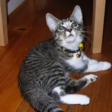

label=5 (cat)
Prediction: 5 (cat)


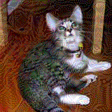

Prediction: 7 (clock)


In [ ]:
def adversarialPGD(
    model: torch.nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    epsilon: float = 4 / 255,
    alpha: float = 2 / 255,
    n_iters: int = 1,
    random_init: bool = False,
) -> torch.Tensor:
    """
    Find an input xᵃᵈᵛ within x±ε pushing `model(xᵃᵈᵛ)` away from y (maximizing loss, unless alpha is negative).

    Uses 'Projective Gradient Descent' with learning rate `alpha` and `n_iters` iterations, as introduced in:
    Madry et al., "Towards Deep Learning Models Resistant to Adversarial Attacks", ICRL 2018
    https://openreview.net/forum?id=rJzIBfZAb

    Assumes x is 0..1-valued and keeps it in these bounds (i.e., it expects unnormalized images).
    """
    was_training = model.training
    model.eval()
    x = x.clone().detach()
    with torch.no_grad():
        x_min = torch.clamp(x - epsilon, min=0)
        x_max = torch.clamp(x + epsilon, max=1)

        if random_init:
            x = x + torch.empty_like(x).uniform_(-epsilon, epsilon)
            x.clamp_(x_min, x_max)

    for _ in range(n_iters):
        x.requires_grad = True
        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(logits, y)
        with torch.no_grad():
            x_grad = torch.autograd.grad(loss, x)[0]
            # We could also:
            #   loss.backward()
            #   x_grad = x.grad.detach()
            # but then we'd nedd to temporarily set requires_grad=False on all model parameters.
            x = x.detach() + alpha * x_grad.sign()
            x.clamp_(x_min, x_max)
            x = x.detach()

    if was_training:
        model.train()
    return x.requires_grad_(False)


def example(device="cuda") -> None:
    model = get_model(eval=True).to(device)

    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[510]
    display_image_tensor(img)
    print(f"{label=} ({dataset.classes[label]})")

    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    pred = model(img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")

    adv_img = normalize(adversarialPGD(model, unnormalize(img), label, epsilon=20 / 255, n_iters=100))
    display_image_tensor(adv_img[0])
    pred = model(adv_img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")


example()


## 3. AdvProp

Training on adversarial examples unfortunately tends to decrease accuracy on plain (unmodified) images a lot.<br>
The authors of [Adversarial Examples Improve Image Recognition](https://arxiv.org/abs/1911.09665) hypothesize that<br>
this is because adversarial examples (and the model activations they induce) follow different distributions.<br>
They propose addressing that by using auxilliary batch-norm-s for the adversarial images.

#### 3a: Implementation
Note that:
* Parameters (weights and biases of the affine transform applied after normalizing) should be the same for plain and adversarial images; only the running mean and variance (the buffers) are distinct.
* During evaluation, the plain batch-norms should be used.

In [ ]:


class AdvPropBatchNorm(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.bn = module
        self.aux_bn = deepcopy(module)

        # shared weight and bias
        # running parameters are separate
        self.aux_bn.weight = self.bn.weight
        self.aux_bn.bias = self.bn.bias

        # is_adv is dynamically set by the model wrapper
        # self.is_adv = False # default

    def forward(self, x):
        if not self.training:
            # clean bn for evaluation
            return self.bn(x)
        return self.aux_bn(x) if self.is_adv else self.bn(x)


class AdvPropModel(torch.nn.Module):
    def __init__(self, base_model: torch.nn.Module):
        super().__init__()
        self.base_model = base_model
        # a simple model wrapper to add is_adv flag

    def forward(self, x, is_adv: bool = False):
        def _set_is_adv(module):
            if isinstance(module, AdvPropBatchNorm):
                module.is_adv = is_adv

        self.base_model.apply(_set_is_adv)
        return self.base_model(x)


def replace_batchnorm(model: torch.nn.Module) -> None:
    for name, module in model.named_children():
        if isinstance(module, torch.nn.BatchNorm2d):
            setattr(model, name, AdvPropBatchNorm(module))
        elif len(list(module.children())) > 0:
            replace_batchnorm(module) # recursive



In [ ]:
class AdvPropTrainer(Trainer):
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = "cuda",
        n_iters: int = 1,
        epsilon: float = 4 / 255,
        alpha: float = 2 / 255,
        adv_ratio: float = 0.25,
    ):
        super().__init__(
            lr=lr, weight_decay=weight_decay, batch_norm_momentum=batch_norm_momentum, n_epochs=n_epochs, device=device
        )
        self.n_iters = n_iters
        self.epsilon = epsilon
        self.alpha = alpha
        self.adv_ratio = adv_ratio

    

    def train_epoch(
        self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()
        n_correct = 0
        n_total = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")

        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)
            adv_batch = adversarialPGD(model, image_batch, label_batch, self.epsilon, self.alpha, self.n_iters)
            # TODO: adv_batch should be created using the auxilliary BN
            # note adversarialPGD uses `eval` mode, but is not an evaluation

            # TODO: correct calling of adversarialPGD
            # adversarialPGD() should be called as normalize(adversarialPGD(model, unnormalize(x), ...), otherwise it clamps inputs (which are centered around zero) to be non-negative.

            optimizer.zero_grad()

            logits_clean = model(image_batch, is_adv=False)
            logits_adv = model(adv_batch, is_adv=True)

            loss_clean = torch.nn.CrossEntropyLoss()(logits_clean, label_batch)
            loss_adv = torch.nn.CrossEntropyLoss()(logits_adv, label_batch)

            loss = (1 - self.adv_ratio) * loss_clean + self.adv_ratio * loss_adv

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                n_correct += (logits_clean.argmax(dim=1) == label_batch).sum().item()
                n_total += len(label_batch)
            accuracy = n_correct / n_total
            progress_bar.set_postfix({"train-acc": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})

    

#### 3b: Evaluation

Comparison of Trainer and AdvPropTrainer (using default hyperparameters, 10 epochs, in particular).<br>

In [ ]:


# The Original Trainer
trainer = Trainer()
results_original = trainer.train(get_model())


val=90.3 %	alt=43.0 %	


Train epoch   1: 100%|██████████| 79/79 [01:30<00:00,  1.14s/it, train-acc=65.6 %, lr=0.0002]


val=91.0 %	alt=54.0 %	


Train epoch   2: 100%|██████████| 79/79 [01:22<00:00,  1.05s/it, train-acc=75.1 %, lr=0.000194]


val=91.6 %	alt=53.2 %	


Train epoch   3: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=78.2 %, lr=0.000188]


val=92.7 %	alt=53.4 %	


Train epoch   4: 100%|██████████| 79/79 [01:22<00:00,  1.05s/it, train-acc=79.5 %, lr=0.000183]


val=93.3 %	alt=55.2 %	


Train epoch   5: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, train-acc=80.2 %, lr=0.000177]


val=93.1 %	alt=53.2 %	


Train epoch   6: 100%|██████████| 79/79 [01:23<00:00,  1.05s/it, train-acc=81.8 %, lr=0.000172]


val=94.6 %	alt=54.7 %	


Train epoch   7: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=82.6 %, lr=0.000167]


val=94.5 %	alt=54.5 %	


Train epoch   8: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=82.7 %, lr=0.000162]


val=94.8 %	alt=54.0 %	


Train epoch   9: 100%|██████████| 79/79 [01:24<00:00,  1.08s/it, train-acc=83.4 %, lr=0.000157]


val=94.6 %	alt=53.3 %	


Train epoch  10: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it, train-acc=84.0 %, lr=0.000152]


val=95.1 %	alt=53.2 %	


**Discussion**

The above implementation of AdvProp shows slight improvement over the original model on the alt dataset (±2%), showing some improved robustness against texture-altered images. At the same time, the performance on the val dataset is comparable in both (±0.3%) with the AdvProp model surpassing the original by a small margin. Overall, this suggests some degree of generalizing power that AdvProp architecture brings against texture-altered images.

Possible future exploration includes more comprehensive tests on different strengths of the adversarial PGD attacks and different algorithms for generating adversarial images like FGSM or even simple perturbation-augmentation functions like the earlier implemented blur, pixelize and noise functions, but now with AdvProp architecture.

In [ ]:
# AdvPropTrainer
model = get_model()

replace_batchnorm(model)
advprop_model = AdvPropModel(model)
# advprop_model # check

advprop_trainer = AdvPropTrainer()
results_advprop = advprop_trainer.train(advprop_model)



val=90.3 %	alt=43.0 %	


Train epoch   1: 100%|██████████| 79/79 [01:42<00:00,  1.30s/it, train-acc=66.2 %, lr=0.0002]


val=91.8 %	alt=53.2 %	


Train epoch   2: 100%|██████████| 79/79 [01:38<00:00,  1.25s/it, train-acc=75.6 %, lr=0.000194]


val=91.2 %	alt=54.5 %	


Train epoch   3: 100%|██████████| 79/79 [01:36<00:00,  1.22s/it, train-acc=78.0 %, lr=0.000188]


val=92.3 %	alt=55.1 %	


Train epoch   4: 100%|██████████| 79/79 [01:35<00:00,  1.21s/it, train-acc=80.1 %, lr=0.000183]


val=93.3 %	alt=57.4 %	


Train epoch   5: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it, train-acc=80.8 %, lr=0.000177]


val=94.1 %	alt=56.2 %	


Train epoch   6: 100%|██████████| 79/79 [01:35<00:00,  1.21s/it, train-acc=81.7 %, lr=0.000172]


val=94.1 %	alt=57.2 %	


Train epoch   7: 100%|██████████| 79/79 [01:39<00:00,  1.26s/it, train-acc=81.7 %, lr=0.000167]


val=94.5 %	alt=56.5 %	


Train epoch   8: 100%|██████████| 79/79 [01:37<00:00,  1.23s/it, train-acc=82.6 %, lr=0.000162]


val=95.5 %	alt=54.3 %	


Train epoch   9: 100%|██████████| 79/79 [01:38<00:00,  1.25s/it, train-acc=83.0 %, lr=0.000157]


val=94.9 %	alt=55.0 %	


Train epoch  10: 100%|██████████| 79/79 [01:41<00:00,  1.29s/it, train-acc=83.4 %, lr=0.000152]


val=95.4 %	alt=55.0 %	


## 4. SparseTopK

Another technique to improve robustness against style and pattern changes was proposed in
[Emergence of Shape Bias in CNNs through Activation Sparsity](https://openreview.net/forum?id=QzcZb3fWmW)
(you do not need to read the paper).
The idea is simple: in between some layers, enforce activation sparsity by zeroing out all but the top say 20% activations (by absolute value).
The hope is that the strong activations, which we keep, encode the more generalizable shape information.

More formally `SparseTopK`, for a fixed fraction $k$ like $20\%$, should be a module that for an input $x \in \mathbb{R}^{C \times H \times W}$ outputs:
$$ \begin{align*}
    x_{\text{out}}[c,h,w] &= x[c,h,w]\quad &&\text{ if } |x[c,h,w]| \geq \text{top-k-percentile}(x[c,:,:]) \\
                          &= 0 \quad &&\text{ otherwise}
\end{align*} $$


In [ ]:
class SparseTopK(torch.nn.Module):
    def __init__(self, k: float):
        super().__init__()
        self.k = k
        assert 0 <= k <= 1, f"Expected 0 ≤ k ≤ 1, got {k}."

    def forward(self, x: torch.Tensor) -> torch.Tensor:
         
        B, C, H, W = x.shape
        num_elements = H * W
        abs_x = torch.abs(x)

        k_th_idx = int((1 - self.k) * num_elements) # k-th as index
        threshold, _ = torch.kthvalue(abs_x.view(B, C, -1), k_th_idx + 1, dim=-1)
        threshold = threshold.view(B, C, 1, 1)

        x = torch.where(abs_x >= threshold, x, 0)

        return x


def example_sparse() -> None:
    model = get_model()
    # The paper tests on ResNet18 and suggests inserting one SparseTopK(0.2) module after the second layer.
    # We'll do something similar for our model, EfficientNetB0.
    model.features[1][0].block.insert(3, SparseTopK(0.2))

    Trainer().train(model)


example_sparse()

val=76.0 %	alt=31.7 %	


Train epoch   1: 100%|██████████| 79/79 [01:35<00:00,  1.21s/it, train-acc=51.5 %, lr=0.0002]


val=84.5 %	alt=51.2 %	


Train epoch   2: 100%|██████████| 79/79 [01:26<00:00,  1.09s/it, train-acc=64.3 %, lr=0.000194]


val=84.7 %	alt=51.8 %	


Train epoch   3: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=68.1 %, lr=0.000188]


val=86.6 %	alt=54.8 %	


Train epoch   4: 100%|██████████| 79/79 [01:25<00:00,  1.09s/it, train-acc=70.6 %, lr=0.000183]


val=87.7 %	alt=53.9 %	


Train epoch   5: 100%|██████████| 79/79 [01:27<00:00,  1.10s/it, train-acc=72.0 %, lr=0.000177]


val=88.2 %	alt=55.3 %	


Train epoch   6: 100%|██████████| 79/79 [01:26<00:00,  1.10s/it, train-acc=72.8 %, lr=0.000172]


val=88.4 %	alt=54.6 %	


Train epoch   7: 100%|██████████| 79/79 [01:25<00:00,  1.09s/it, train-acc=74.6 %, lr=0.000167]


val=90.3 %	alt=55.3 %	


Train epoch   8: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=75.3 %, lr=0.000162]


val=90.2 %	alt=54.3 %	


Train epoch   9: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, train-acc=75.8 %, lr=0.000157]


val=90.8 %	alt=53.8 %	


Train epoch  10: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=75.7 %, lr=0.000152]


val=91.5 %	alt=55.0 %	



**Discussion**

The above implementation of SparseTopK slightly improves the robustness of the model to altered images (alt dataset) - the accuracy on val dataset converged on around \~91% which is slightly worse than the original model (±2%), while the accuracy on alt dataset converged on around \~55%, which in turn is a slight improvement over the original model (±2%), which, similarly to AdvProp, suggests some degree of improved generalization regarding variations in texture.
